<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/BNL_Scripts/XRD_File_Corrections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XRD File Corrections

This script helps make various corrections to XRD files in an xy format. All files must be located in an accessible google drive directory.

Current Corrections Available:

*   Background Subtraction




## Imports

In [28]:
from google.colab import drive  #allows downloading and accessing files on drive
from google.colab import files  #allows downloading and accessing files on drive
import shutil                   #allows uploading files to drive
import glob                     #useful for collecting and organizing files
import csv
import numpy as np              #math library
import pandas as pd             #data organization library
import scipy as sp              #math library
from scipy import interpolate
import re                       #string processing library
from scipy import optimize      #math fitting library
import matplotlib.pylab as plt  #allows for plotting
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Extract Data from Google Drive

In [2]:
# log into google drive with your account
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# Directory Locations for information
XRD_files_path = '/content/drive/Shareddrives/BNL_June_2024/DataFiles/Cu1Ni2_200C/integration/'
XRD_tmps_path = '/content/drive/Shareddrives/BNL_June_2024/DataFiles/Cu1Ni2_200C/scalar_data/Cu1Ni2_mixed_LongRunInfo.csv'
XRD_subtraction_path = '/content/drive/Shareddrives/BNL_June_2024/DataFiles/Quartz_Capillary_no_FG_PDF_1sec/integration/'
XRD_subtraction_tmps_path = '/content/drive/Shareddrives/BNL_June_2024/DataFiles/Quartz_Capillary_no_FG_PDF_1sec/scalar_data/Quartz_Capillary_no_FG_PDF_1sec_LongRunInfo.csv'

In [61]:
# Read in XRD file temperature data
data1 = pd.read_csv(XRD_tmps_path)
data1 = data1
data1 = data1.sort_values(by='time')
# Convert eurotherm (i.e. control) temperature into sample temperature using a fit
C0,C1,C2,C3 = 4.91, 0.8519, 0.0005649, -2.536*10**(-7)
data1['sample_temp'] = round(C3*data1['eurotherm_temperature']**3 + C2*data1['eurotherm_temperature']**2 + C1*data1['eurotherm_temperature']**1 + C0,1)

# Read in XRD subtraction file temperature data
data2  = pd.read_csv(XRD_subtraction_tmps_path)
data2 = data2
data2 = data2.sort_values(by='time')
# Convert eurotherm (i.e. control) temperature into sample temperature using a fit
C0,C1,C2,C3 = 4.91, 0.8519, 0.0005649, -2.536*10**(-7)
data2['sample_temp'] = round(C3*data2['eurotherm_temperature']**3 + C2*data2['eurotherm_temperature']**2 + C1*data2['eurotherm_temperature']**1 + C0,1)

data1
#data2

,time,pe2_stats1_total,eurotherm_temperature,eurotherm_power,chi_max,chi_argmax,gr_max,gr_argmax,seq_num,date,sample_temp
0,1.718161e+09,25015118.0,30.0,3.5,3.016831,114.825850,0.0,0.0,1,225607,31.0
1,1.718161e+09,25008683.0,30.0,5.2,3.016831,115.129540,0.0,0.0,2,225607,31.0
2,1.718161e+09,25020222.0,30.0,7.9,3.016831,115.574980,0.0,0.0,3,225607,31.0
3,1.718161e+09,25010940.0,30.0,9.7,3.016831,116.017784,0.0,0.0,4,225607,31.0
4,1.718161e+09,25018313.0,30.0,10.7,3.016831,115.568070,0.0,0.0,5,225607,31.0
...,...,...,...,...,...,...,...,...,...,...,...
3795,1.718165e+09,24994009.0,166.0,16.0,3.009864,115.982410,0.0,0.0,946,234345,160.7
3796,1.718165e+09,24986291.0,166.0,16.2,3.009864,115.958330,0.0,0.0,947,234345,160.7
3797,1.718165e+09,24995185.0,165.0,17.2,3.009864,116.208730,0.0,0.0,948,234345,159.7
3798,1.718165e+09,24993342.0,165.0,17.5,3.009864,116.509540,0.0,0.0,949,234345,159.7


In [62]:
XRD_files = glob.glob(XRD_files_path + '*.xy')                # collect all XRD data files in a list
XRD_sub_files = glob.glob(XRD_subtraction_path + '*.xy')      # collect all Quartz XRD files to subtract in a list
print(len(XRD_files), len(XRD_sub_files))                     # check the lengths of the two lists

2193 469


In [98]:
'''
Try and correlate the XRD files to the correct Quartz XRD file to subtract based on sample temperature.
A directory will be returened with new csv files in an xy format. The x column will hold the original
x spacing from the XRD file. The y cloumn will hold the XRD data with the Quartz intensity subtracted off.
 Most but not necessarily all XRD files will have an associated Quartz file to subtract. In cases where
there are no associated Quartz file, a new file with the subtraction will not be created.
'''
for file in XRD_files[:3]:
  XRD_data = pd.read_csv(file, skiprows=1, header=None, names=['x','y'], sep="\s+") # create a dataframe of the XRD data
  XRD_info = re.findall(r'\d+',file)                                           # find XRD identifier info encoded in file name
  XRD_temp = data1[(data1['seq_num']==int(XRD_info[-1])) &
                   (data1['date']==int(XRD_info[-4]))]['sample_temp'].item()   # find the sample temperature of the XRD file
  XRD_sub_file = data2[data2['sample_temp']==XRD_temp]                         # find the associated Quartz XRD with the same sample temperature (if none an empty dataframe will be returned)
  if XRD_sub_file.empty:                                                       # if the dataframe is empty skip the current XRD file and move to the next
    print("{} temp was skipped".format(XRD_temp))
    continue
  else:                                                                        # if the dataframe is not empty...
    XRD_sub_seq_num = int(XRD_sub_file.iloc[0]['seq_num'].item())              # find the associated Quartz file 'seq_num' identifier, if more than one file, take the first
    XRD_sub_date = int(XRD_sub_file.iloc[0]['date'].item())                    # find the associated Quartz file 'date' identifier, if more than one file, take the first
    XRD_sub_file_name = glob.glob(XRD_subtraction_path
                                +'*{}*-{}*.xy'.format(XRD_sub_date,XRD_sub_seq_num))  # find the filename of the XRD data to subtract
    #print(XRD_sub_file_name)                                                         # prints the filename of the Quartz data to subtract
    sub_data = pd.read_csv(XRD_sub_file_name[0], skiprows=1, header=None, names=['x','y'], sep="\s+")  # create a dataframe of the XRD data to subtract

    sub_extrap = np.interp(XRD_data.x, sub_data.x, sub_data.y)                 # extrapolate Quartz intensity onto the x-axis used for CuNi sample
    sub_extrap_scaled = sub_extrap/sub_extrap.max()*XRD_data.y[:53].max()#*.95 # scales the Quartz intensity to be 95% of the peak Quartz intensity in the CuNi samples
    XRD_data_w_sub = XRD_data.y - sub_extrap_scaled                            # finds the new XRD data with the Quartz intensity subtracted off
    new_data = pd.DataFrame({'tth':XRD_data.x, 'I':XRD_data_w_sub})            # creates a new dataframe that includes the XRD data x-axis and the new XRD intenisty with the Quartz removed
    n = data1[(data1['seq_num']==int(XRD_info[-1])) &
                   (data1['date']==int(XRD_info[-4]))].index                   # finds the index number of the XRD file. Will be used in naming the new file with corrected intensity
    new_name = XRD_files_path + 'bkg_removed/{}_{}.csv'.format(n[0],XRD_temp)  # creates the name of the new file
    #print(new_name)                                                           # prints the name of the new filw
    new_data.to_csv(new_name, header=False, sep='\t', index=False)             #downloads csv file directly to drive with no header, tab separations, and no index

/content/drive/Shareddrives/BNL_June_2024/DataFiles/Cu1Ni2_200C/integration/bkg_removed/1411_160.7.csv
/content/drive/Shareddrives/BNL_June_2024/DataFiles/Cu1Ni2_200C/integration/bkg_removed/1424_158.7.csv
/content/drive/Shareddrives/BNL_June_2024/DataFiles/Cu1Ni2_200C/integration/bkg_removed/1408_161.8.csv


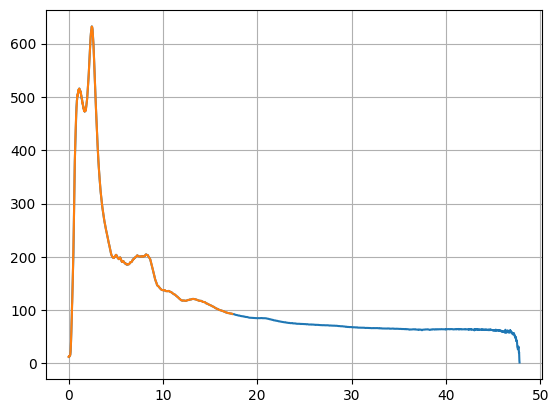

In [99]:
plt.plot(sub_data.x, sub_data.y)
plt.plot(XRD_data.x, sub_extrap)
plt.grid()
plt.plot(XRD_data.x, XRD_data.y, 'o')
plt.plot(XRD_data.x, XRD_data_w_sub, '-')
plt.grid()